In [1]:
from ultralytics import YOLO
from utils.body import BODY_PARTS_NAMES, BODY_CONNECTIONS_DRAW, BODY_CONNECTIONS
import supervision as sv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import cv2
import os

In [2]:
sns.set_style('darkgrid')

In [3]:
model = YOLO('models/yolo11n-pose.pt')
byte_tracker = sv.ByteTrack()

cap = cv2.VideoCapture('data/videos/falls/banana-peel.mp4')

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

scale_percent = 100
width = int(frame_width * scale_percent / 100)
height = int(frame_height * scale_percent / 100)

text_scale = .5
text_thickness = 1

bounding_box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=text_thickness, text_scale=text_scale)
trace_annotator = sv.TraceAnnotator(thickness=2)

while True:
    start_time = time.time()

    ret, frame = cap.read()
    if not ret:
        print("Video terminado")
        break
    
    results = model(frame)[0]
    annotated_frame = frame.copy()
    
    if len(results.keypoints.xy) > 0:
        detections = sv.Detections.from_ultralytics(results)
        detections = byte_tracker.update_with_detections(detections)
        
        labels = [f'#{tracker_id} {results.names[class_id]} {confidence:.2f}' for class_id, confidence, tracker_id in zip(detections.class_id, detections.confidence, detections.tracker_id)]
        annotated_frame = trace_annotator.annotate(annotated_frame, detections)
        annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
        
        for person_idx in range(len(results.keypoints.xy)):
            if results.keypoints.xy[person_idx].size(0) == 0:
                continue
            keypoints = results.keypoints.xy[person_idx]
            body = {part: keypoints[i] for i, part in enumerate(BODY_PARTS_NAMES)}
            
            for group, (connections, color) in BODY_CONNECTIONS_DRAW.items():
                for part_a, part_b in connections:
                    x1, y1 = map(int, body[part_a])
                    x2, y2 = map(int, body[part_b])
                    if x1 == 0 or x2 == 0 or y1 == 0 or y2 == 0:
                        continue
                    cv2.line(annotated_frame, (x1, y1), (x2, y2), color, 2)

                for part_a, _ in connections:
                    x, y = map(int, body[part_a])
                    if x == 0 or y == 0:
                        continue
                    cv2.circle(annotated_frame, (x, y), 4, color, -2)
    
    # Calcular FPS real
    processing_time = time.time() - start_time
    fps_real = 1 / processing_time if processing_time > 0 else 0
    
    # Agregar texto de información
    cv2.putText(annotated_frame, f'{frame_width}x{frame_height}', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, text_scale, (0, 255, 0), text_thickness, cv2.LINE_AA)
    cv2.putText(annotated_frame, f'Real: {fps_real:.2f} FPS', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, text_scale, (0, 0, 255), text_thickness, cv2.LINE_AA)
    cv2.putText(annotated_frame, f'Personas: {len(results.keypoints.xy)}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, text_scale, (255, 0, 0), text_thickness, cv2.LINE_AA)
    
    # out.write(annotated_frame)
    annotated_frame = cv2.resize(annotated_frame, (width, height))
    cv2.imshow('frame', annotated_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

Video terminado


In [ ]:
def extract_keypoints_from_video(video_path: str, model: YOLO,  sequence_length: int = 20, output_path: str = 'keypoints.npy'):
    num_keypoints = 17 * 2
    
    if not os.path.exists(video_path):
        raise FileNotFoundError(f'El archivo de video {video_path} no existe')
    
    cap = cv2.VideoCapture(video_path)
    keypoints_buffer = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break # Video terminado
        
        results = model(frame)[0]
        
        if len(results.keypoints.xy) > 0:
            keypoints = results.keypoints.xy[0].numpy().flatten()
            if keypoints.shape[0] != num_keypoints:
                keypoints = np.pad(keypoints, (0, num_keypoints - keypoints.shape[0]))
        else:
            # keypoints = np.zeros(num_keypoints, dtype=np.float32)
            continue 
            
        keypoints_buffer.append(keypoints)
        
        if len(keypoints_buffer) == sequence_length:
            break
        
    cap.release()
    
    keypoints_buffer = np.array(keypoints_buffer, dtype=np.float32)
    np.save(output_path, keypoints_buffer)
    print(f'Guardado en {output_path}')
    
    return keypoints_buffer

In [17]:
keypoints_videos = extract_keypoints_from_video('data/videos/falls/trust-fall-fail-fall.mp4', model, sequence_length=400, output_path='keypoints.npy')
keypoints_videos.shape


0: 384x640 1 person, 203.4ms
Speed: 4.5ms preprocess, 203.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.0ms
Speed: 2.2ms preprocess, 104.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 131.4ms
Speed: 2.5ms preprocess, 131.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 106.9ms
Speed: 1.6ms preprocess, 106.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 104.0ms
Speed: 2.4ms preprocess, 104.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 84.8ms
Speed: 1.4ms preprocess, 84.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 91.0ms
Speed: 1.9ms preprocess, 91.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 117.6ms
Speed: 2.2ms preprocess, 117.6ms inference, 2.0ms postprocess per image at sha

(400, 34)

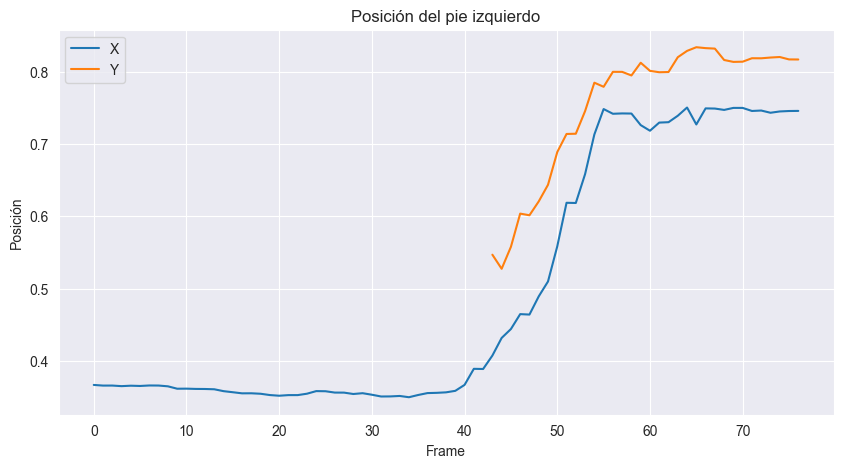

In [18]:
# dibujar el camino del pie izquierdo y derecho en el video
import matplotlib.pyplot as plt
import numpy as np

keypoints = np.load('keypoints.npy')
# normalizar keypoints en el rango [0, 1]
keypoints = keypoints / np.nanmax(keypoints)

keypoints[keypoints == 0] = np.nan
left_foot = keypoints[:, 15:17]

plt.figure(figsize=(10, 5))
plt.plot(left_foot[:, 0], label='X')
plt.plot(left_foot[:, 1], label='Y')
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Posición')
plt.title('Posición del pie izquierdo')
plt.show()


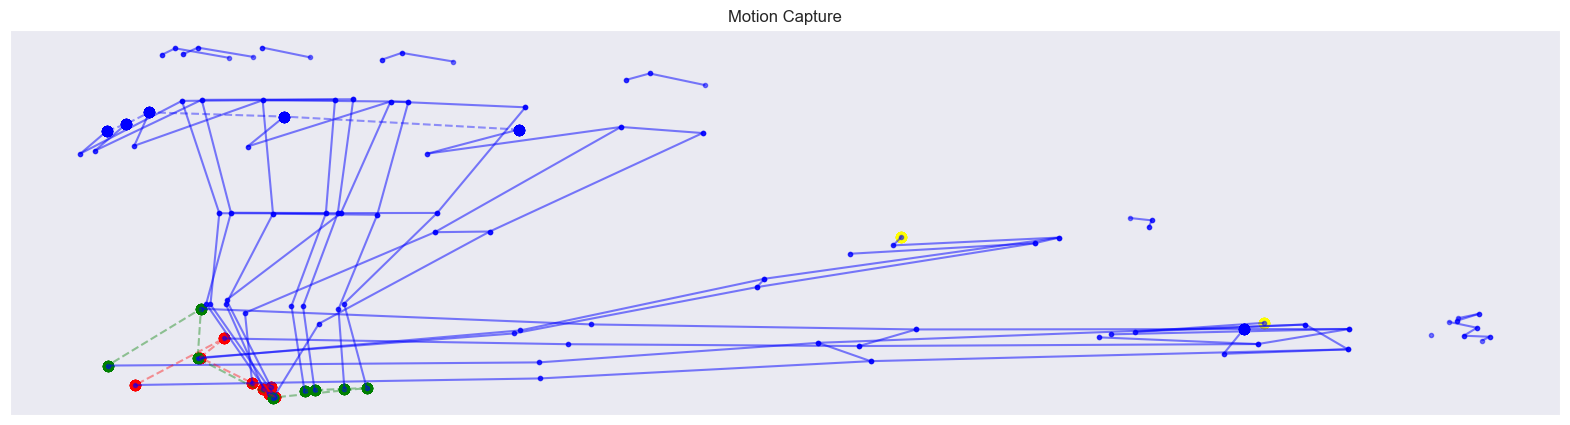

In [19]:
left_foot = keypoints[:, 15:17]
right_foot = keypoints[:, 18:20]

lef_hand = keypoints[:, 9:11]
right_hand = keypoints[:, 10:12]

num_frames = keypoints.shape[0]

plt.figure(figsize=(20, 5))

left_foot_trece = []
right_foot_trece = []
lef_hand_trece = []
right_hand_trece = []

for i in range(0, num_frames, 10):
    kps = keypoints[i].reshape(-1, 2)
    
    for joint1, joint2 in BODY_CONNECTIONS:
        x_values = [kps[joint1, 0], kps[joint2, 0]]
        y_values = [kps[joint1, 1], kps[joint2, 1]]
        plt.plot(x_values, y_values, 'bo-', markersize=3, alpha=0.5)  # Dibujar conexiones
        left_foot_trece.append(kps[15])
        right_foot_trece.append(kps[16])
        lef_hand_trece.append(kps[9])
        right_hand_trece.append(kps[10])
        
left_foot_trece = np.array(left_foot_trece)
plt.plot(left_foot_trece[:, 0], left_foot_trece[:, 1], 'r--', markersize=5, alpha=0.4, label='Left foot')
plt.scatter(left_foot_trece[:, 0], left_foot_trece[:, 1], color='red', s=50, label='Left foot position')

right_foot_trece = np.array(right_foot_trece)
plt.plot(right_foot_trece[:, 0], right_foot_trece[:, 1], 'g--', markersize=5, alpha=0.4, label='Right foot')
plt.scatter(right_foot_trece[:, 0], right_foot_trece[:, 1], color='green', s=50, label='Right foot position')

lef_hand_trece = np.array(lef_hand_trece)
plt.plot(lef_hand_trece[:, 0], lef_hand_trece[:, 1], 'b--', markersize=5, alpha=0.4, label='Left hand')
plt.scatter(lef_hand_trece[:, 0], lef_hand_trece[:, 1], color='blue', s=50, label='Left hand position')

right_hand_trece = np.array(right_hand_trece)
plt.plot(right_hand_trece[:, 0], right_hand_trece[:, 1], 'y--', markersize=5, alpha=0.4, label='Right hand')
plt.scatter(right_hand_trece[:, 0], right_hand_trece[:, 1], color='yellow', s=50, label='Right hand position')
        
# plt.legend()
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.title('Motion Capture')
plt.show()

In [23]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
keypoints_imputed = imputer.fit_transform(keypoints)
keypoints_imputed

array([[    0.31107,     0.17828,     0.31807, ...,     0.83191,     0.38488,     0.82128],
       [    0.31188,      0.1782,     0.31868, ...,     0.83017,     0.38438,      0.8201],
       [    0.31188,     0.17821,      0.3187, ...,     0.83004,     0.38456,        0.82],
       ...,
       [    0.97036,     0.71167,     0.98333, ...,      0.7788,     0.28717,     0.74535],
       [     0.9714,     0.70961,     0.98437, ...,     0.77847,     0.29401,       0.745],
       [    0.97435,     0.71277,     0.98739, ...,     0.79722,     0.28963,     0.76754]], dtype=float32)

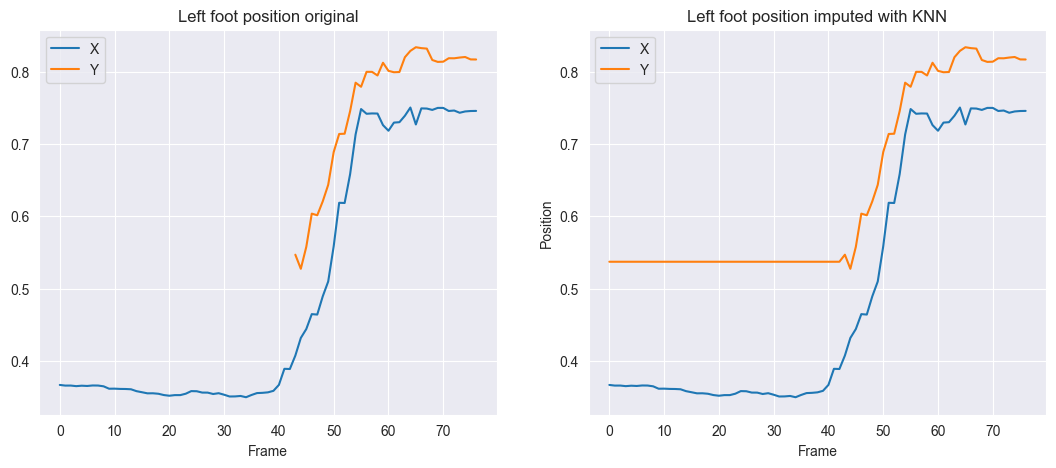

In [24]:
plt.figure(figsize=(13, 5))

left_foot_original = keypoints[:, 15:17]
left_foot_imputed = keypoints_imputed[:, 15:17]

plt.subplot(1, 2, 1)
plt.plot(left_foot_original[:, 0], label='X')
plt.plot(left_foot_original[:, 1], label='Y')
plt.legend()
plt.title('Left foot position original')
plt.xlabel('Frame')
# plt.ylabel('Position')

plt.subplot(1, 2, 2)
plt.plot(left_foot_imputed[:, 0], label='X')
plt.plot(left_foot_imputed[:, 1], label='Y')
plt.legend()
plt.title('Left foot position imputed with KNN')
plt.xlabel('Frame')
plt.ylabel('Position')

plt.show()



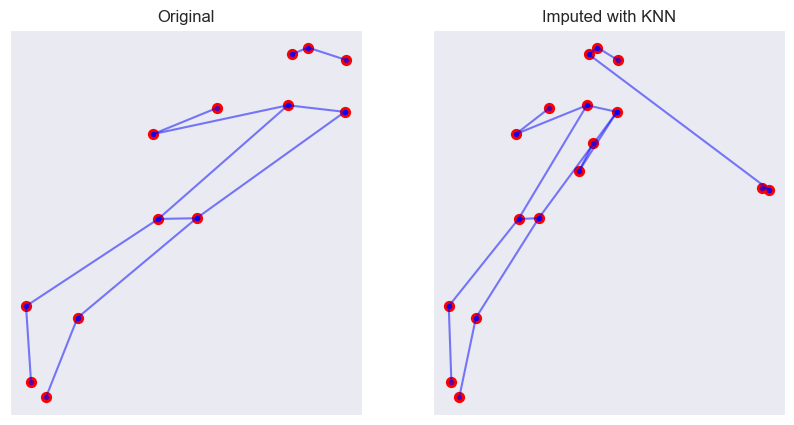

In [25]:
# dibuja el esqueleto de una persona en un frame original y otro imputado

def draw_skeleton(ax, keypoints, title):
    for joint1, joint2 in BODY_CONNECTIONS:
        x_values = [keypoints[joint1, 0], keypoints[joint2, 0]]
        y_values = [keypoints[joint1, 1], keypoints[joint2, 1]]
        ax.plot(x_values, y_values, 'bo-', markersize=3, alpha=0.5)  # Dibujar conexiones
    ax.scatter(keypoints[:, 0], keypoints[:, 1], color='red', s=50, label='Joint position')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

draw_skeleton(axs[0], keypoints[40].reshape(-1, 2), 'Original')
draw_skeleton(axs[1], keypoints_imputed[40].reshape(-1, 2), 'Imputed with KNN')

In [11]:
import cv2
import os
import numpy as np

def get_video_frame_count(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count

def analyze_videos(folder_path):
    frame_counts = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(('.mp4', '.avi', '.mov', '.mkv')):  # Filtra los archivos de video
            video_path = os.path.join(folder_path, filename)
            frames = get_video_frame_count(video_path)
            frame_counts.append(frames)
    
    if frame_counts:
        return {
            "min": int(np.min(frame_counts)),
            "max": int(np.max(frame_counts)),
            "mean": float(np.mean(frame_counts)),
            "median": float(np.median(frame_counts))
        }
    else:
        return "No se encontraron videos en la carpeta."

folder_path = "data/videos/falls"
stats = analyze_videos(folder_path)
print(stats)


{'min': 37, 'max': 206, 'mean': 69.23255813953489, 'median': 64.0}


## Guradar los datos

In [12]:
from utils import extract_keypoints_from_video

In [46]:
video_folders = {
    'data/videos/falls': 1,    # Videos de caídas -> etiqueta 1
    'data/videos/normal': 0,   # Videos sin caídas -> etiqueta 0
    'data/videos/no_fall_static': 0
}

keypoints_sequences = []
labels = []

for folder, label in video_folders.items():
    for filename in os.listdir(folder):
        if not filename.endswith('mp4'):
            continue
        
        video_path = os.path.join(folder, filename)
        keypoints = extract_keypoints_from_video(video_path, model, sequence_length=20)
        
        keypoints_sequences.append(keypoints)
        labels.append(label)
        
keypoints_sequences = np.array(keypoints_sequences)
labels = np.array(labels)

print(keypoints_sequences.shape, labels.shape)

0: 384x640 1 person, 163.8ms
Speed: 6.4ms preprocess, 163.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 168.5ms
Speed: 1.5ms preprocess, 168.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 105.2ms
Speed: 1.5ms preprocess, 105.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 101.6ms
Speed: 2.1ms preprocess, 101.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 96.8ms
Speed: 1.6ms preprocess, 96.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 94.8ms
Speed: 2.0ms preprocess, 94.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 95.3ms
Speed: 1.9ms preprocess, 95.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 86.4ms
Speed: 1.8ms preprocess, 86.4ms inference, 0.8ms postprocess per image at shape (1

In [47]:
keypoints_sequences[0].shape

(20, 34)

In [48]:
# los 0 son los valores faltantes pasarlos a nan (67, 10, 34) 
for i in range(keypoints_sequences.shape[0]):
    keypoints_sequences[i][keypoints_sequences[i] == 0] = np.nan
    
keypoints_sequences[0]

array([[     457.41,      348.04,      454.52,      342.63,      451.33,      350.89,      457.83,      342.98,      453.49,      363.69,      473.63,      332.29,      495.35,      392.97,      518.45,      285.93,       543.7,      420.24,      533.48,      268.23,      584.25,      427.65,      565.86,
              339.8,      579.04,      368.87,      568.22,      319.22,      586.97,      349.18,      612.91,      314.47,      617.13,      333.69],
       [     455.95,      352.05,      452.83,      347.18,      453.25,      353.68,       454.1,      345.17,      456.99,      361.44,      473.21,      330.95,      491.47,      384.39,      513.37,      280.62,      537.99,      414.32,      531.04,         261,      558.63,      407.96,      564.74,
             332.35,      575.16,      356.85,      576.31,      317.73,      582.62,      342.62,      621.82,      325.19,       624.9,       338.4],
       [     457.01,      348.34,      454.52,       342.8,      451.36,      350.

In [49]:
# imputar los valores faltantes con KNN
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
keypoints_sequences_imputed = imputer.fit_transform(keypoints_sequences.reshape(-1, 34)).reshape(-1, 20, 34)
keypoints_sequences_imputed.shape

(111, 20, 34)

In [50]:
# normalizar los keypoints
keypoints_sequences_normalized = keypoints_sequences_imputed / np.nanmax(keypoints_sequences_imputed)
keypoints_sequences_normalized = np.nan_to_num(keypoints_sequences_normalized)
keypoints_sequences_normalized.shape

(111, 20, 34)

In [51]:
keypoints_sequences_normalized[0][0].min(), keypoints_sequences_normalized[0][0].max()

(np.float32(0.3262458), np.float32(0.7506169))

In [52]:
np.save('keypoints_sequences.npy', keypoints_sequences_normalized)
np.save('labels.npy', labels)